# Quantum Dynamic Pricing
#### Here we use the OLA CABS dataset for predicting the fare prices of cabs using Quantum Neural Network
#### The same code can be use on any dynamic pricing dataset for determining price of product/service offered  

## Installing required Libraries 

In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2

## Exploring and Processing Dataset

In [3]:
import pandas as pd
data = pd.read_csv('../input/ola-dynamic/data.csv')
data

,Unnamed: 0,ID,vendor+AF8-id,pickup+AF8-loc,drop+AF8-loc,driver+AF8-tip,mta+AF8-tax,distance,pickup+AF8-time,drop+AF8-time,num+AF8-passengers,toll+AF8-amount,payment+AF8-method,rate+AF8-code,stored+AF8-flag,extra+AF8-charges,improvement+AF8-charge,total+AF8-amount
0,0,0,1,170.0,233.0,1.83,0.5,0.70,4/4/2017 17:59,4/4/2017 18:05,1.0,0.0,1.0,1.0,N,1.0,0.3,9.13
1,1,1,2,151.0,243.0,3.56,0.5,4.64,4/3/2017 19:03,4/3/2017 19:20,1.0,0.0,1.0,1.0,N,1.0,0.3,21.36
2,2,2,2,68.0,90.0,1.50,0.5,1.29,4/3/2017 15:06,4/3/2017 15:12,2.0,0.0,1.0,1.0,N,0.0,0.3,8.80
3,3,3,2,142.0,234.0,1.50,0.5,2.74,4/4/2017 8:10,4/4/2017 8:27,1.0,0.0,1.0,1.0,N,0.0,0.3,14.80
4,4,4,2,238.0,238.0,0.00,0.5,0.45,4/5/2017 14:02,4/5/2017 14:05,6.0,0.0,2.0,1.0,N,0.0,0.3,4.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,14995,2,41.0,238.0,1.00,0.5,2.11,4/3/2017 7:01,4/3/2017 7:08,1.0,0.0,1.0,1.0,N,0.0,0.3,9.80
14996,14996,14996,1,237.0,161.0,1.00,0.5,1.10,4/6/2017 8:01,4/6/2017 8:13,1.0,0.0,1.0,1.0,N,0.0,0.3,10.80
14997,14997,14997,2,264.0,264.0,0.00,0.5,1.00,4/5/2017 17:13,4/5/2017 17:22,5.0,0.0,2.0,1.0,N,1.0,0.3,8.30
14998,14998,14998,2,140.0,50.0,2.00,0.5,4.38,4/3/2017 20:09,4/3/2017 20:30,1.0,0.0,1.0,1.0,N,0.5,0.3,20.80


In [4]:
# Making pickup time and drop time columns use able for training the Quantum Neural Network
data['pickup+AF8-time']=pd.to_datetime(data['pickup+AF8-time'])
data['drop+AF8-time']=pd.to_datetime(data['drop+AF8-time'])

duration = (data['drop+AF8-time'] - data['pickup+AF8-time'])
data.drop(columns=['pickup+AF8-time','drop+AF8-time',],inplace=True)
timeinsec=duration.dt.total_seconds()
data['timeinsec']=timeinsec
data.loc[data['ID'] >=0, 'ID'] = 1.0

In [5]:
# Dropping columns that wont affect fare price 
drops = ['vendor+AF8-id','stored+AF8-flag','Unnamed: 0','total+AF8-amount']
x = data.drop(drops,axis=1)
y = data['total+AF8-amount']

In [6]:
# Converting x and y to numpy arrays for using MinMaxScaler 
import numpy as np
x = np.array(x)
y = np.array(y)

## Creating Quantum Neural Network and training the QNN 
#### Here we use Tensorflow Quantum and Cirq for creating the neural network. Other libraries such as Pennylane and Qiskit can also be used.  

In [ ]:
# Importing required libraries for QNN
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
import numpy as np
from sklearn import datasets as ds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


x = MinMaxScaler().fit_transform(x)
y = (y - np.min(y)) / (np.max(y) - np.min(y))



# Quantum Neural Network
def convert_data(data, qubits, test=False):
    cs = []
    for i in data:
        cir = cirq.Circuit()
        for j in range(len(qubits)):
            cir += cirq.rx(i[j] * np.pi).on(qubits[j])
            cir += cirq.ry(i[j] * np.pi).on(qubits[j])
        cs.append(cir)
    if test:
        return tfq.convert_to_tensor([cs])
    return tfq.convert_to_tensor(cs)

def encode(data, labels, qubits):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2, random_state=43)
    return convert_data(X_train, qubits), convert_data(X_test, qubits), y_train, y_test

def layer(circuit, qubits, params):
    for i in range(len(qubits)):
        if i + 1 < len(qubits):
            circuit += cirq.CNOT(qubits[i], qubits[i + 1])
        circuit += cirq.ry(params[i * 2]).on(qubits[i])
        circuit += cirq.rz(params[i * 2 + 1]).on(qubits[i])
    circuit += cirq.CNOT(qubits[-1], qubits[0])
    return circuit

def model_circuit(qubits, depth):
    cir = cirq.Circuit()
    num_params = depth * 2 * len(qubits)
    params = sympy.symbols("q0:%d"%num_params)
    for i in range(depth):
        cir = layer(cir, qubits, params[i * 2 * len(qubits):i * 2 * len(qubits) + 2 * len(qubits)])
    return cir



qs = [cirq.GridQubit(0, i) for i in range(13)]
d = 3                                                   # depth of circuit
X_train, X_test, y_train, y_test = encode(x, y, qs)     # preparing training and testing dataset 
c = model_circuit(qs, d)                                # creating Quantum Neural Network i.e our model 
print(c)                                    

readout_operators = [cirq.Z(qs[0])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)



# There are two types of differentiator 1. ParameterShift and 2. Adjoint 
# The adjoint differentiator works realtively faster than parametershift on classical hardware 
# ParameterShift will work faster and more efficient on Quantum Hardware  
# The ParameterShift differentiator can also be used by uncommenting it and commenting Adjoint differentiator

#layer1 = tfq.layers.PQC(c, readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift())(inputs) 
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
vqc = tf.keras.models.Model(inputs=inputs, outputs=layer1)
vqc.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=3e-3))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



# Here we train the neural network for 10 epochs only to save the training time.
# Increasing the number of epochs and depth of circuit might result in more accurate outputs 
v_history = vqc.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[callback])


## Plotting training and validation loss

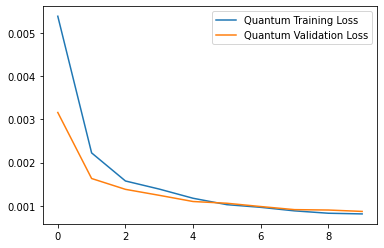

<Figure size 432x288 with 0 Axes>

In [8]:

plt.plot(v_history.history['loss'], label='Quantum Training Loss')
plt.plot(v_history.history['val_loss'], label='Quantum Validation Loss')
plt.legend()
plt.show()
plt.savefig("Ola_Dynamic")